### Neural Network Modelling

### Import relevant libraries and datasets

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from joblib import dump, load

2024-04-26 15:52:05.595582: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df = pd.read_csv('../../Data/processed/weatherAUS_imputed.csv')
display(df.head())

,Date,Location,Year,Month,RainToday,RainTomorrow,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindGustDir_angle,Latitude,Longitude,Cloud,Pressure,Temperature,Humidity,temp_fluctuation
0,2009-01-01,Cobar,2009,1,0.0,0.0,-0.254034,1.452543,1.231645,0.544048,0.367568,-0.016581,0.134517,-0.346762,-1.566909,1.483789,-2.239319,1.266185
1,2009-01-02,Cobar,2009,1,0.0,0.0,-0.254034,2.092290,1.417426,-0.274399,0.142577,-0.016581,0.134517,-1.337620,-0.534263,0.523016,-2.103988,-0.123978
2,2009-01-03,Cobar,2009,1,0.0,0.0,-0.254034,1.589632,1.497046,-0.795229,-0.307405,-0.016581,0.134517,-1.337620,-0.664246,1.892307,-2.753579,1.531952
3,2009-01-04,Cobar,2009,1,0.0,0.0,-0.254034,1.178365,0.780464,0.395239,-1.432358,-0.016581,0.134517,-0.346762,-0.787008,1.756134,-1.400263,1.450178
4,2009-01-05,Cobar,2009,1,0.0,0.0,-0.254034,1.315454,1.205105,-0.720824,1.267530,-0.016581,0.134517,-0.544934,-0.765344,1.839351,-1.535595,1.102637


In [3]:
#confusion matrix, classification report
def confusion_matrix_classification_report(model):
    pred_prob = model.predict(X_test) > 0.5
    pred = (pred_prob > 0.5).astype(int)
    mat = confusion_matrix(y_test, pred)
    labels = ['True', 'False']
 
    sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)
 
    plt.xlabel('Predicted label')
    plt.ylabel('Actual label')
    
    print(classification_report(y_test, pred))

In [4]:
#training and validation accuracy plot
def training_validation_accuracy_plot(history):
    acc = history.history['accuracy']
    val = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1, 1)
    
    plt.plot(epochs, acc, '-', label='Training accuracy')
    plt.plot(epochs, val, ':', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.plot()

### Neural Network Classification

### 1. Without any over oder undersampling

### 1.1 Baseline Neural Network

In [5]:
data = df.drop(columns=['RainTomorrow', 'Location', 'Date'])
target = df['RainTomorrow']
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42, stratify=target)

In [6]:
baseline_model = Sequential()
baseline_model.add(Dense(1, input_dim=X_train.shape[1], activation='sigmoid'))
baseline_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 16        
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


2024-04-26 15:52:07.428220: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [7]:
training_history1 = baseline_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=100)

Epoch 1/20
542/542 [==============================] - 1s 1ms/step - loss: 1.0589 - accuracy: 0.7854 - val_loss: 0.4023 - val_accuracy: 0.8187
Epoch 2/20
542/542 [==============================] - 1s 2ms/step - loss: 0.3828 - accuracy: 0.8299 - val_loss: 0.3567 - val_accuracy: 0.8415
Epoch 3/20
542/542 [==============================] - 1s 2ms/step - loss: 0.3648 - accuracy: 0.8386 - val_loss: 0.3685 - val_accuracy: 0.8364
Epoch 4/20
542/542 [==============================] - 1s 2ms/step - loss: 0.3568 - accuracy: 0.8428 - val_loss: 0.3513 - val_accuracy: 0.8481
Epoch 5/20
542/542 [==============================] - 1s 1ms/step - loss: 0.3585 - accuracy: 0.8416 - val_loss: 0.3440 - val_accuracy: 0.8497
Epoch 6/20
542/542 [==============================] - 1s 1ms/step - loss: 0.3577 - accuracy: 0.8414 - val_loss: 0.3480 - val_accuracy: 0.8492
Epoch 7/20
542/542 [==============================] - 1s 1ms/step - loss: 0.3515 - accuracy: 0.8448 - val_loss: 0.3373 - val_accuracy: 0.8531
Epoch 

In [8]:
df_hist1 = pd.DataFrame(training_history1.history)
df_hist1

,loss,accuracy,val_loss,val_accuracy
0,1.058896,0.785364,0.402315,0.818678
1,0.382822,0.829863,0.356657,0.841491
2,0.364830,0.838630,0.368484,0.836397
3,0.356756,0.842765,0.351261,0.848062
4,0.358451,0.841602,0.344036,0.849686
5,0.357732,0.841381,0.347987,0.849243
6,0.351460,0.844814,0.337318,0.853082
7,0.353183,0.843614,0.336806,0.853230
8,0.350605,0.845939,0.336481,0.853378
9,0.354056,0.844334,0.356640,0.845330


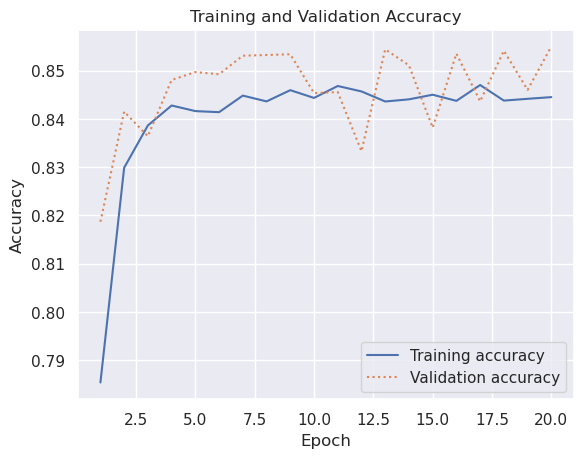

In [9]:
training_validation_accuracy_plot(training_history1)

424/424 [==============================] - 0s 824us/step
              precision    recall  f1-score   support

         0.0       0.88      0.94      0.91     10652
         1.0       0.72      0.53      0.61      2893

    accuracy                           0.86     13545
   macro avg       0.80      0.74      0.76     13545
weighted avg       0.85      0.86      0.85     13545



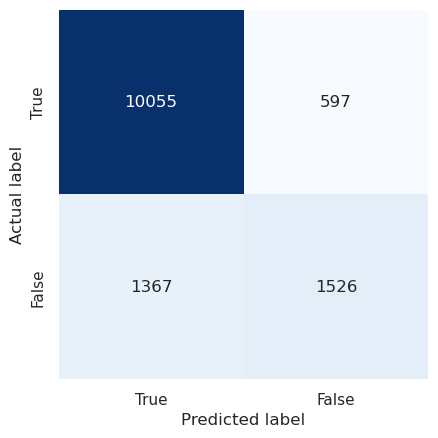

In [10]:
confusion_matrix_classification_report(baseline_model)

### 1.2 Adding more layers 

In [11]:
model2 = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [12]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
training_history2 = model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=100)

Epoch 1/20
542/542 [==============================] - 3s 4ms/step - loss: 1.2582 - accuracy: 0.7824 - val_loss: 0.3576 - val_accuracy: 0.8414
Epoch 2/20
542/542 [==============================] - 1s 3ms/step - loss: 0.4480 - accuracy: 0.8136 - val_loss: 0.4689 - val_accuracy: 0.7790
Epoch 3/20
542/542 [==============================] - 3s 5ms/step - loss: 0.4777 - accuracy: 0.8095 - val_loss: 0.3665 - val_accuracy: 0.8478
Epoch 4/20
542/542 [==============================] - 2s 4ms/step - loss: 0.4403 - accuracy: 0.8171 - val_loss: 0.4600 - val_accuracy: 0.8266
Epoch 5/20
542/542 [==============================] - 2s 4ms/step - loss: 0.4357 - accuracy: 0.8217 - val_loss: 0.3828 - val_accuracy: 0.8276
Epoch 6/20
542/542 [==============================] - 2s 3ms/step - loss: 0.4480 - accuracy: 0.8161 - val_loss: 0.4167 - val_accuracy: 0.8120
Epoch 7/20
542/542 [==============================] - 2s 5ms/step - loss: 0.4080 - accuracy: 0.8257 - val_loss: 0.4820 - val_accuracy: 0.8180
Epoch 

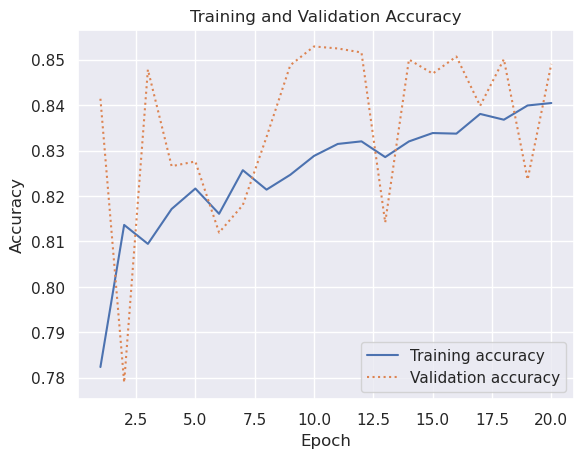

In [14]:
training_validation_accuracy_plot(training_history2)

424/424 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     10652
         1.0       0.79      0.40      0.53      2893

    accuracy                           0.85     13545
   macro avg       0.82      0.68      0.72     13545
weighted avg       0.84      0.85      0.83     13545



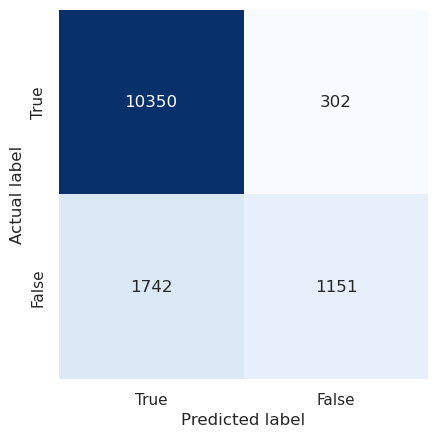

In [15]:
confusion_matrix_classification_report(model2)

### 1.3 GridSearch

In [16]:
def build_classifier(learn_rate):
    # Initialising the DNN
    classifier = Sequential()
    classifier.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
    classifier.add(Dense(64, activation='relu'))
    classifier.add(Dense(1, activation='sigmoid'))
    opt = Adam(learning_rate=learn_rate)
    classifier.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return classifier


In [17]:
"""
classifier = KerasClassifier(build_fn = build_classifier)

# grid search epochs, batch size and optimizer
epochs = [10]
batches = [100]
lr=[0.3,0.2,0.1, 0.03, 0.02, 0.01]
param_grid = dict(epochs=epochs, batch_size=batches, learn_rate=lr)
grid = GridSearchCV(estimator=classifier, param_grid=param_grid)
grid_result = grid.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
"""

'\nclassifier = KerasClassifier(build_fn = build_classifier)\n\n# grid search epochs, batch size and optimizer\nepochs = [10]\nbatches = [100]\nlr=[0.3,0.2,0.1, 0.03, 0.02, 0.01]\nparam_grid = dict(epochs=epochs, batch_size=batches, learn_rate=lr)\ngrid = GridSearchCV(estimator=classifier, param_grid=param_grid)\ngrid_result = grid.fit(X_train, y_train)\n\n# summarize results\nprint("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))\n'

In [18]:
#dump(grid_result.best_params_, 'grid_dnn.joblib')

In [19]:
grid_dnn = load('grid_dnn.joblib')

In [20]:
grid_dnn

{'batch_size': 100, 'epochs': 10, 'learn_rate': 0.03}

### 1.4 Model with best parameters

In [21]:
model_best = build_classifier(0.03)

In [22]:
training_history_best = model_best.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, batch_size=100)

Epoch 1/300
542/542 [==============================] - 3s 4ms/step - loss: 4.2648 - accuracy: 0.8074 - val_loss: 0.3605 - val_accuracy: 0.8492
Epoch 2/300
542/542 [==============================] - 3s 5ms/step - loss: 0.3657 - accuracy: 0.8394 - val_loss: 0.3537 - val_accuracy: 0.8413
Epoch 3/300
542/542 [==============================] - 2s 3ms/step - loss: 0.3611 - accuracy: 0.8418 - val_loss: 0.3434 - val_accuracy: 0.8516
Epoch 4/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3573 - accuracy: 0.8428 - val_loss: 0.3644 - val_accuracy: 0.8422
Epoch 5/300
542/542 [==============================] - 3s 6ms/step - loss: 0.3603 - accuracy: 0.8411 - val_loss: 0.3434 - val_accuracy: 0.8509
Epoch 6/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3556 - accuracy: 0.8437 - val_loss: 0.3428 - val_accuracy: 0.8504
Epoch 7/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3559 - accuracy: 0.8433 - val_loss: 0.3408 - val_accuracy: 0.8528

Epoch 58/300
542/542 [==============================] - 2s 3ms/step - loss: 0.3574 - accuracy: 0.8448 - val_loss: 0.3411 - val_accuracy: 0.8524
Epoch 59/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3581 - accuracy: 0.8444 - val_loss: 0.3553 - val_accuracy: 0.8496
Epoch 60/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3561 - accuracy: 0.8450 - val_loss: 0.3600 - val_accuracy: 0.8510
Epoch 61/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3564 - accuracy: 0.8461 - val_loss: 0.3426 - val_accuracy: 0.8526
Epoch 62/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3557 - accuracy: 0.8456 - val_loss: 0.3467 - val_accuracy: 0.8536
Epoch 63/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3531 - accuracy: 0.8465 - val_loss: 0.3429 - val_accuracy: 0.8516
Epoch 64/300
542/542 [==============================] - 3s 6ms/step - loss: 0.3527 - accuracy: 0.8458 - val_loss: 0.3420 - val_accuracy:

Epoch 115/300
542/542 [==============================] - 3s 5ms/step - loss: 0.3558 - accuracy: 0.8456 - val_loss: 0.3768 - val_accuracy: 0.8317
Epoch 116/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3583 - accuracy: 0.8451 - val_loss: 0.3653 - val_accuracy: 0.8474
Epoch 117/300
542/542 [==============================] - 3s 5ms/step - loss: 0.3537 - accuracy: 0.8474 - val_loss: 0.3465 - val_accuracy: 0.8484
Epoch 118/300
542/542 [==============================] - 3s 5ms/step - loss: 0.3580 - accuracy: 0.8453 - val_loss: 0.3391 - val_accuracy: 0.8523
Epoch 119/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3554 - accuracy: 0.8458 - val_loss: 0.3419 - val_accuracy: 0.8535
Epoch 120/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3556 - accuracy: 0.8457 - val_loss: 0.3457 - val_accuracy: 0.8532
Epoch 121/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3554 - accuracy: 0.8454 - val_loss: 0.3507 - val_ac

542/542 [==============================] - 2s 4ms/step - loss: 0.3539 - accuracy: 0.8461 - val_loss: 0.3511 - val_accuracy: 0.8513
Epoch 172/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3547 - accuracy: 0.8443 - val_loss: 0.3393 - val_accuracy: 0.8533
Epoch 173/300
542/542 [==============================] - 3s 6ms/step - loss: 0.3570 - accuracy: 0.8454 - val_loss: 0.3449 - val_accuracy: 0.8546
Epoch 174/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3552 - accuracy: 0.8447 - val_loss: 0.3437 - val_accuracy: 0.8534
Epoch 175/300
542/542 [==============================] - 3s 6ms/step - loss: 0.3580 - accuracy: 0.8448 - val_loss: 0.3389 - val_accuracy: 0.8531
Epoch 176/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3566 - accuracy: 0.8457 - val_loss: 0.3412 - val_accuracy: 0.8530
Epoch 177/300
542/542 [==============================] - 3s 5ms/step - loss: 0.3566 - accuracy: 0.8463 - val_loss: 0.3381 - val_accuracy: 0.8543

542/542 [==============================] - 3s 6ms/step - loss: 0.3555 - accuracy: 0.8461 - val_loss: 0.3723 - val_accuracy: 0.8448
Epoch 228/300
542/542 [==============================] - 2s 4ms/step - loss: 0.3573 - accuracy: 0.8459 - val_loss: 0.3792 - val_accuracy: 0.8470
Epoch 229/300
542/542 [==============================] - 3s 5ms/step - loss: 0.3577 - accuracy: 0.8453 - val_loss: 0.3398 - val_accuracy: 0.8548
Epoch 230/300
542/542 [==============================] - 3s 5ms/step - loss: 0.3572 - accuracy: 0.8459 - val_loss: 0.3417 - val_accuracy: 0.8533
Epoch 231/300
542/542 [==============================] - 3s 5ms/step - loss: 0.3544 - accuracy: 0.8464 - val_loss: 0.3466 - val_accuracy: 0.8515
Epoch 232/300
542/542 [==============================] - 3s 6ms/step - loss: 0.3565 - accuracy: 0.8458 - val_loss: 0.3408 - val_accuracy: 0.8529
Epoch 233/300
542/542 [==============================] - 3s 5ms/step - loss: 0.3548 - accuracy: 0.8464 - val_loss: 0.3778 - val_accuracy: 0.8444

542/542 [==============================] - 2s 4ms/step - loss: 0.3559 - accuracy: 0.8451 - val_loss: 0.3401 - val_accuracy: 0.8538
Epoch 284/300
542/542 [==============================] - 3s 5ms/step - loss: 0.3569 - accuracy: 0.8462 - val_loss: 0.3386 - val_accuracy: 0.8532
Epoch 285/300
542/542 [==============================] - 3s 5ms/step - loss: 0.3548 - accuracy: 0.8458 - val_loss: 0.4032 - val_accuracy: 0.8517
Epoch 286/300
542/542 [==============================] - 4s 6ms/step - loss: 0.3556 - accuracy: 0.8445 - val_loss: 0.3567 - val_accuracy: 0.8534
Epoch 287/300
542/542 [==============================] - 4s 7ms/step - loss: 0.3592 - accuracy: 0.8458 - val_loss: 0.3588 - val_accuracy: 0.8411
Epoch 288/300
542/542 [==============================] - 3s 5ms/step - loss: 0.3550 - accuracy: 0.8469 - val_loss: 0.3447 - val_accuracy: 0.8493
Epoch 289/300
542/542 [==============================] - 3s 5ms/step - loss: 0.3544 - accuracy: 0.8467 - val_loss: 0.3618 - val_accuracy: 0.8449

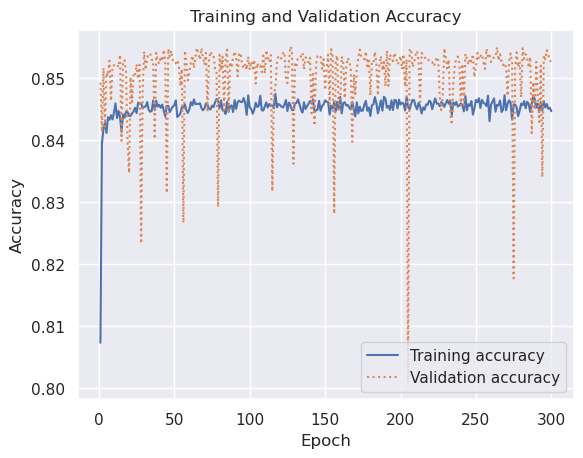

In [23]:
training_validation_accuracy_plot(training_history_best)

424/424 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

         0.0       0.87      0.96      0.91     10652
         1.0       0.75      0.47      0.58      2893

    accuracy                           0.85     13545
   macro avg       0.81      0.71      0.74     13545
weighted avg       0.84      0.85      0.84     13545



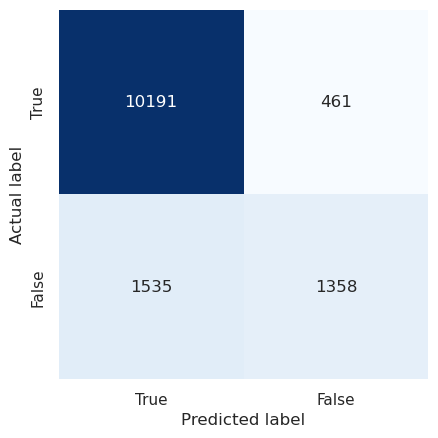

In [24]:
confusion_matrix_classification_report(model_best)

The models we got so far seem quite unstable. This is certainly due the stochastic nature of the model, i.e stochastic gradient descent introduced randomness through mini-batch sampling which can cause the optimization process to converge to different local minima. This seems to be the case for our models. 

Let's see if a) adding Dropout and early stopping b) adding random over and undersampling b) adding more layers solves part of the problem. 

### 2. Model with Dropout and early stopping

In [25]:
def model_with_dropout(X):
    model = Sequential()
    model.add(Dense(128, input_dim=X.shape[1], activation='relu', name='Dense1'))
    model.add(Dropout(0.25, name='Dropout1'))
    model.add(Dense(64, input_dim=X.shape[1],activation='relu', name='Dense2'))
    model.add(Dropout(0.25, name='Dropout2'))
    model.add(Dense(32, activation='relu', name='Dense3'))
    model.add(Dropout(0.25, name='Dropout3'))
    model.add(Dense(16, activation='relu', name='Dense4'))
    model.add(Dropout(0.25, name='Dropout4'))
    model.add(Dense(1, activation='sigmoid', name='Dense5'))
    opt = Adam(learning_rate=0.03)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [26]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True)

In [27]:
model4 = model_with_dropout(X_train)

In [28]:
training_history4 = model4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=100,callbacks=[early_stopping])

Epoch 1/100
542/542 [==============================] - 4s 6ms/step - loss: 1.6077 - accuracy: 0.7825 - val_loss: 0.5189 - val_accuracy: 0.7864
Epoch 2/100
542/542 [==============================] - 3s 5ms/step - loss: 0.5192 - accuracy: 0.7864 - val_loss: 0.5189 - val_accuracy: 0.7864
Epoch 3/100
542/542 [==============================] - 4s 7ms/step - loss: 0.5193 - accuracy: 0.7864 - val_loss: 0.5191 - val_accuracy: 0.7864
Epoch 4/100
542/542 [==============================] - 4s 7ms/step - loss: 0.5195 - accuracy: 0.7864 - val_loss: 0.5189 - val_accuracy: 0.7864
Epoch 5/100
542/542 [==============================] - 3s 5ms/step - loss: 0.5205 - accuracy: 0.7864 - val_loss: 0.5190 - val_accuracy: 0.7864
Epoch 6/100
542/542 [==============================] - 2s 5ms/step - loss: 0.5192 - accuracy: 0.7864 - val_loss: 0.5187 - val_accuracy: 0.7864
Epoch 7/100
542/542 [==============================] - 3s 5ms/step - loss: 0.5195 - accuracy: 0.7864 - val_loss: 0.5187 - val_accuracy: 0.7864

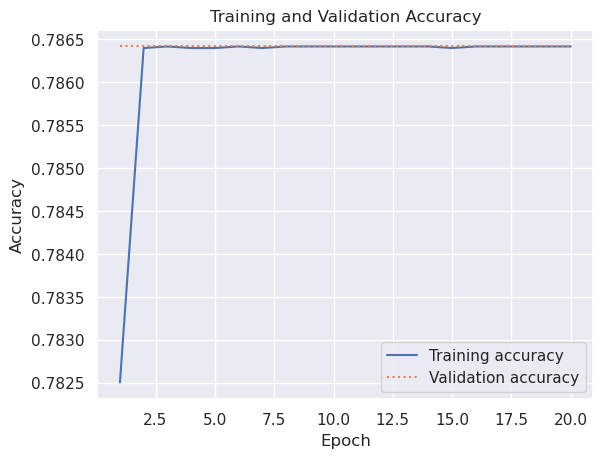

In [29]:
training_validation_accuracy_plot(training_history4)

424/424 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88     10652
         1.0       0.00      0.00      0.00      2893

    accuracy                           0.79     13545
   macro avg       0.39      0.50      0.44     13545
weighted avg       0.62      0.79      0.69     13545



/home/claudia/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claudia/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claudia/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


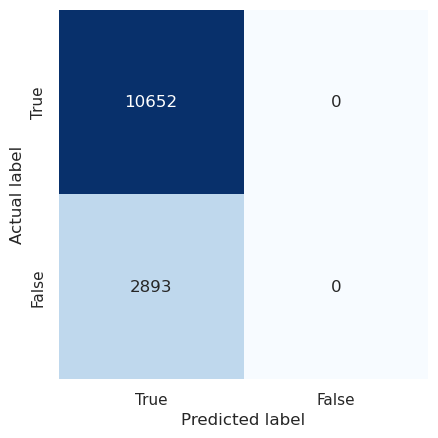

In [30]:
confusion_matrix_classification_report(model4)

### 3. Over and undersampling

In [188]:
def model_without_dropout(X):
    model = Sequential()
    model.add(Dense(128, input_dim=X.shape[1], activation='relu', name='Dense1'))
    model.add(Dense(64,activation='relu', name='Dense2'))
    model.add(Dense(32, activation='relu', name='Dense3'))
    model.add(Dense(16, activation='relu', name='Dense4'))
    model.add(Dense(1, activation='sigmoid', name='Dense5'))
    opt = Adam(learning_rate=0.03)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

### 3.1 Random oversampling 

In [189]:
ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(X_train,y_train)
model_sampling = model_without_dropout(X_train_ros)

In [190]:
training_history_ros = model_sampling.fit(X_train_ros, y_train_ros, validation_data=(X_test, y_test), epochs=100, 
                                 batch_size=100, callbacks=[early_stopping])

Epoch 1/100
853/853 [==============================] - 4s 4ms/step - loss: 1.3402 - accuracy: 0.7201 - val_loss: 0.3710 - val_accuracy: 0.8374
Epoch 2/100
853/853 [==============================] - 4s 4ms/step - loss: 0.4668 - accuracy: 0.7778 - val_loss: 0.4586 - val_accuracy: 0.8134
Epoch 3/100
853/853 [==============================] - 4s 4ms/step - loss: 0.4621 - accuracy: 0.7808 - val_loss: 0.4315 - val_accuracy: 0.8156
Epoch 4/100
853/853 [==============================] - 4s 4ms/step - loss: 0.4602 - accuracy: 0.7836 - val_loss: 0.7476 - val_accuracy: 0.5958
Epoch 5/100
853/853 [==============================] - 3s 4ms/step - loss: 0.4609 - accuracy: 0.7835 - val_loss: 0.4570 - val_accuracy: 0.7889
Epoch 6/100
853/853 [==============================] - 4s 4ms/step - loss: 0.4546 - accuracy: 0.7856 - val_loss: 0.4095 - val_accuracy: 0.8193


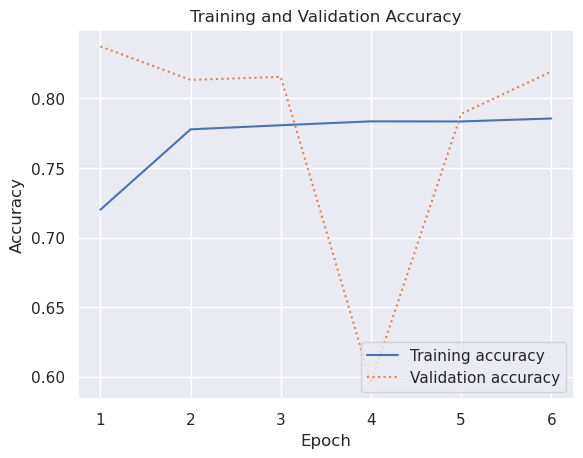

In [191]:
training_validation_accuracy_plot(training_history_ros)

424/424 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90     10652
         1.0       0.61      0.67      0.64      2893

    accuracy                           0.84     13545
   macro avg       0.76      0.78      0.77     13545
weighted avg       0.84      0.84      0.84     13545



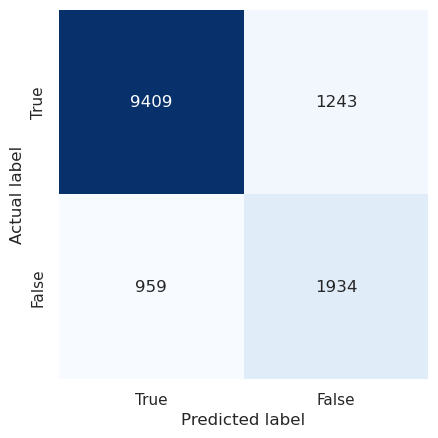

In [192]:
confusion_matrix_classification_report(model_sampling)

###  3.1 SMOTE 

In [193]:
sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)
model_sampling = model_without_dropout(X_train_sm)

In [194]:
training_history_sm = model_sampling.fit(X_train_sm, y_train_sm, validation_data=(X_test, y_test), epochs=100, 
                                 batch_size=100, callbacks=[early_stopping])

Epoch 1/100
853/853 [==============================] - 5s 5ms/step - loss: 1.7686 - accuracy: 0.6661 - val_loss: 0.4285 - val_accuracy: 0.8161
Epoch 2/100
853/853 [==============================] - 4s 4ms/step - loss: 0.4671 - accuracy: 0.7776 - val_loss: 0.3990 - val_accuracy: 0.8210
Epoch 3/100
853/853 [==============================] - 4s 5ms/step - loss: 0.4533 - accuracy: 0.7863 - val_loss: 0.5097 - val_accuracy: 0.7296
Epoch 4/100
853/853 [==============================] - 5s 5ms/step - loss: 0.4533 - accuracy: 0.7883 - val_loss: 0.5472 - val_accuracy: 0.7152
Epoch 5/100
853/853 [==============================] - 5s 6ms/step - loss: 0.4527 - accuracy: 0.7883 - val_loss: 0.6520 - val_accuracy: 0.6796
Epoch 6/100
853/853 [==============================] - 6s 7ms/step - loss: 0.4534 - accuracy: 0.7871 - val_loss: 0.3864 - val_accuracy: 0.8154
Epoch 7/100
853/853 [==============================] - 4s 4ms/step - loss: 0.4482 - accuracy: 0.7906 - val_loss: 0.4300 - val_accuracy: 0.8134

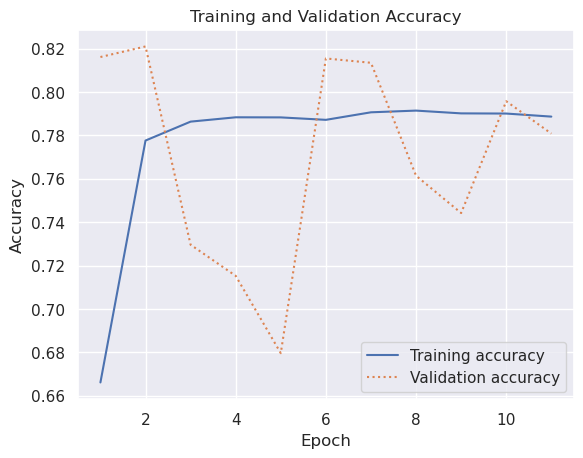

In [195]:
training_validation_accuracy_plot(training_history_sm)

424/424 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

         0.0       0.93      0.83      0.88     10652
         1.0       0.55      0.77      0.64      2893

    accuracy                           0.82     13545
   macro avg       0.74      0.80      0.76     13545
weighted avg       0.85      0.82      0.83     13545



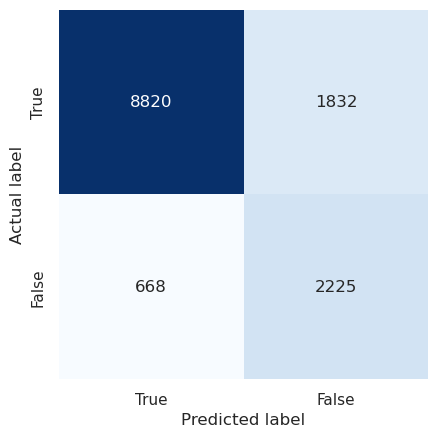

In [196]:
confusion_matrix_classification_report(model_sampling)

### 3.3 Random Undersampling

In [197]:
rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train,y_train)
model_sampling = model_without_dropout(X_train_rus)

In [198]:
training_history_rus = model_sampling.fit(X_train_rus, y_train_rus, validation_data=(X_test, y_test), epochs=100, 
                                 batch_size=100, callbacks=[early_stopping])

Epoch 1/100
232/232 [==============================] - 2s 5ms/step - loss: 3.4538 - accuracy: 0.5061 - val_loss: 0.7003 - val_accuracy: 0.2136
Epoch 2/100
232/232 [==============================] - 1s 5ms/step - loss: 0.6934 - accuracy: 0.4973 - val_loss: 0.6948 - val_accuracy: 0.2136
Epoch 3/100
232/232 [==============================] - 1s 5ms/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.7088 - val_accuracy: 0.2136
Epoch 4/100
232/232 [==============================] - 1s 6ms/step - loss: 0.6935 - accuracy: 0.4950 - val_loss: 0.6879 - val_accuracy: 0.7864
Epoch 5/100
232/232 [==============================] - 1s 6ms/step - loss: 0.6934 - accuracy: 0.5027 - val_loss: 0.7008 - val_accuracy: 0.2136
Epoch 6/100
232/232 [==============================] - 1s 5ms/step - loss: 0.6934 - accuracy: 0.4979 - val_loss: 0.7128 - val_accuracy: 0.2136
Epoch 7/100
232/232 [==============================] - 1s 5ms/step - loss: 0.6935 - accuracy: 0.5036 - val_loss: 0.7043 - val_accuracy: 0.2136

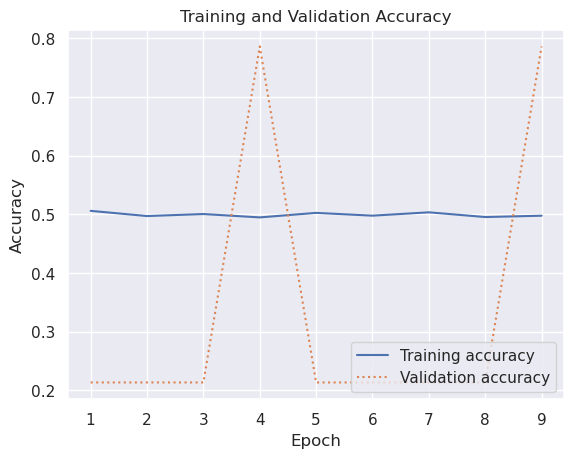

In [199]:
training_validation_accuracy_plot(training_history_rus)

424/424 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.88     10652
         1.0       0.00      0.00      0.00      2893

    accuracy                           0.79     13545
   macro avg       0.39      0.50      0.44     13545
weighted avg       0.62      0.79      0.69     13545



/home/claudia/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claudia/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/claudia/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


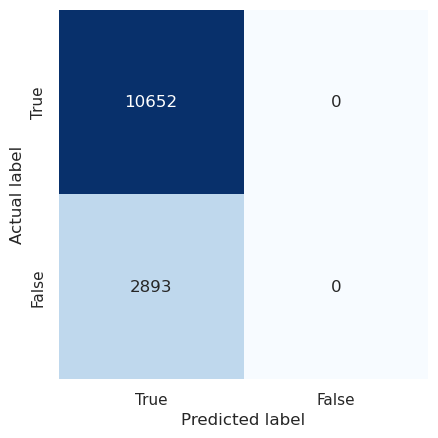

In [200]:
confusion_matrix_classification_report(model_sampling)

### 4. Batch Normalization

In [201]:
model5 = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),  # input layer
    Dense(32, activation='relu'),  # hidden layer
    BatchNormalization(),
    Dense(16, activation='relu'),  # hidden layer
    BatchNormalization(),
    Dense(1, activation='sigmoid')  # output layer with sigmoid activation for binary classification
])

# Compile the model
model5.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model5.summary()

Model: "sequential_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_63 (Dense)            (None, 64)                1024      
                                                                 
 dense_64 (Dense)            (None, 32)                2080      
                                                                 
 batch_normalization_18 (Bat  (None, 32)               128       
 chNormalization)                                                
                                                                 
 dense_65 (Dense)            (None, 16)                528       
                                                                 
 batch_normalization_19 (Bat  (None, 16)               64        
 chNormalization)                                                
                                                                 
 dense_66 (Dense)            (None, 1)               

In [202]:
training_history5 = model5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=100, callbacks=[early_stopping])

Epoch 1/100
542/542 [==============================] - 4s 6ms/step - loss: 0.4098 - accuracy: 0.8158 - val_loss: 7.5094 - val_accuracy: 0.2136
Epoch 2/100
542/542 [==============================] - 3s 5ms/step - loss: 0.3431 - accuracy: 0.8481 - val_loss: 3.8595 - val_accuracy: 0.2136
Epoch 3/100
542/542 [==============================] - 3s 5ms/step - loss: 0.3395 - accuracy: 0.8490 - val_loss: 9.5821 - val_accuracy: 0.2136
Epoch 4/100
542/542 [==============================] - 2s 4ms/step - loss: 0.3389 - accuracy: 0.8490 - val_loss: 20.6162 - val_accuracy: 0.7864
Epoch 5/100
542/542 [==============================] - 3s 5ms/step - loss: 0.3395 - accuracy: 0.8494 - val_loss: 0.5166 - val_accuracy: 0.7965
Epoch 6/100
542/542 [==============================] - 4s 8ms/step - loss: 0.3374 - accuracy: 0.8500 - val_loss: 2.1124 - val_accuracy: 0.7864
Epoch 7/100
542/542 [==============================] - 2s 4ms/step - loss: 0.3368 - accuracy: 0.8494 - val_loss: 0.5982 - val_accuracy: 0.645

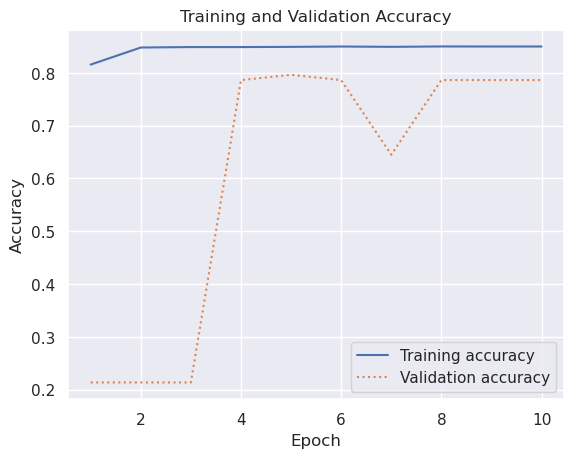

In [203]:
training_validation_accuracy_plot(training_history5)

424/424 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

         0.0       0.79      1.00      0.89     10652
         1.0       0.94      0.05      0.10      2893

    accuracy                           0.80     13545
   macro avg       0.87      0.52      0.49     13545
weighted avg       0.83      0.80      0.72     13545



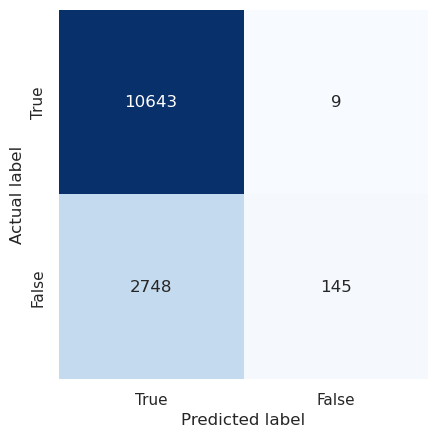

In [204]:
confusion_matrix_classification_report(model5)

### 5. Learning Rate Scheduling

In [205]:
model6 = Sequential([
    Dense(64, activation='relu', input_dim=X_train.shape[1]),  # input layer
    Dense(32, activation='relu'),  # hidden layer
    Dense(16, activation='relu'),  # hidden layer
    Dense(1, activation='sigmoid')  # output layer with sigmoid activation for binary classification
])

In [206]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced by a factor of 0.1 after every 10 epochs.
    """
    learning_rate = 0.03
    if 20 > epoch > 10:
        learning_rate *= 0.04
    if epoch >= 20:
        learning_rate *= 0.05
    return learning_rate

In [207]:
# Compile the model
opt = Adam(learning_rate=0.01)
model6.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
model6.summary()

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_67 (Dense)            (None, 64)                1024      
                                                                 
 dense_68 (Dense)            (None, 32)                2080      
                                                                 
 dense_69 (Dense)            (None, 16)                528       
                                                                 
 dense_70 (Dense)            (None, 1)                 17        
                                                                 
Total params: 3,649
Trainable params: 3,649
Non-trainable params: 0
_________________________________________________________________


In [208]:
# Define the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train the model with learning rate scheduling
training_history6 = model6.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=100, callbacks=[early_stopping,lr_scheduler])

Epoch 1/100
542/542 [==============================] - 3s 5ms/step - loss: 1.4375 - accuracy: 0.7954 - val_loss: 0.3693 - val_accuracy: 0.8372 - lr: 0.0300
Epoch 2/100
542/542 [==============================] - 2s 4ms/step - loss: 0.3712 - accuracy: 0.8369 - val_loss: 0.3626 - val_accuracy: 0.8405 - lr: 0.0300
Epoch 3/100
542/542 [==============================] - 2s 4ms/step - loss: 0.3623 - accuracy: 0.8398 - val_loss: 0.3504 - val_accuracy: 0.8497 - lr: 0.0300
Epoch 4/100
542/542 [==============================] - 2s 4ms/step - loss: 0.3595 - accuracy: 0.8426 - val_loss: 0.3422 - val_accuracy: 0.8489 - lr: 0.0300
Epoch 5/100
542/542 [==============================] - 3s 6ms/step - loss: 0.3644 - accuracy: 0.8396 - val_loss: 0.3472 - val_accuracy: 0.8506 - lr: 0.0300
Epoch 6/100
542/542 [==============================] - 2s 4ms/step - loss: 0.3579 - accuracy: 0.8432 - val_loss: 0.3562 - val_accuracy: 0.8474 - lr: 0.0300
Epoch 7/100
542/542 [==============================] - 3s 6ms/st

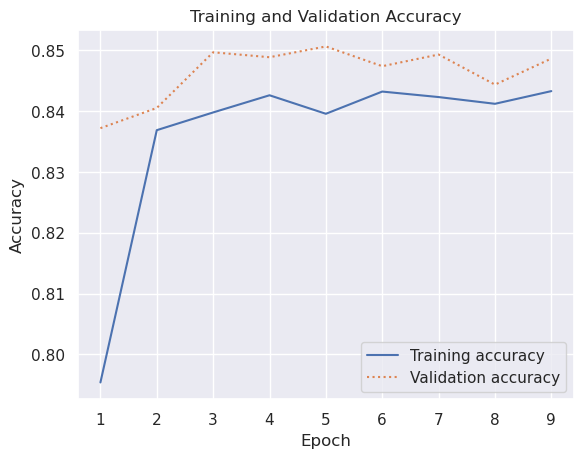

In [209]:
training_validation_accuracy_plot(training_history6)

424/424 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     10652
         1.0       0.77      0.41      0.54      2893

    accuracy                           0.85     13545
   macro avg       0.82      0.69      0.72     13545
weighted avg       0.84      0.85      0.83     13545



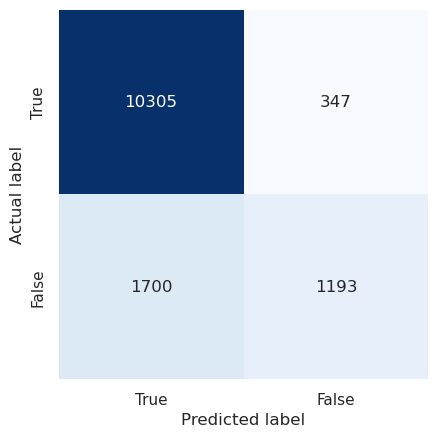

In [210]:
confusion_matrix_classification_report(model6)

### 6. Conclusion

The Neural Network Model does not perform well. It is unstable and gives low precision and recall scores no matter the number of epoch or batch_size. Different learning rates also do no seem to give a better result, nor does increasing the number of layers. It seems that the Gradient Descent converges to different local minima, meaning that the function we are trying to minimize is not convex and the algorithm becomes unpredictable. 

Unfortunately, the gradient descent algorithm is one of the only algorithms that can be used in practice because it is the only efficient optimization algorithm given our computational capabilities.